# Titre

Notes initiales.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import roc_auc_score, accuracy_score

In [2]:
from xgboost import XGBClassifier
df = pd.read_csv('/Users/guenounraphael/Desktop/HEC/Algo_Fairness/dataproject2025.csv')

In [3]:
def advanced_feature_engineering(df):
    """Feature engineering plus sophistiqué"""
    df_processed = df.copy()
    
    exclude_columns = [
        'target', 'Predicted probabilities', 'Predictions',   
        'Unnamed: 0', 'zip_code', 'Pct_afro_american'
    ]
    
    X = df_processed.drop(columns=exclude_columns)
    y = df_processed['target'].astype(int)
    
    emp_length_mapping = {
        '< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4, 
        '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9, 
        '10+ years': 10
    }
    X['emp_length'] = X['emp_length'].map(emp_length_mapping).fillna(0)
    
    title_counts = X['emp_title'].value_counts()
    top_titles = title_counts.head(20).index
    X['emp_title_grouped'] = np.where(X['emp_title'].isin(top_titles), 
                                      X['emp_title'], 'other')
    
    X['is_manager'] = X['emp_title'].str.contains('manager|director|supervisor', 
                                                  case=False, na=False).astype(int)
    X['is_analyst'] = X['emp_title'].str.contains('analyst|specialist', 
                                                  case=False, na=False).astype(int)
    X['is_engineer'] = X['emp_title'].str.contains('engineer|developer|programmer', 
                                                   case=False, na=False).astype(int)
    
    # One-hot encoding pour emp_title_grouped
    title_dummies = pd.get_dummies(X['emp_title_grouped'], prefix='title', drop_first=True)
    X = pd.concat([X.drop(columns=['emp_title', 'emp_title_grouped']), title_dummies], axis=1)
    
    # 3. Amélioration grade et sub_grade
    grade_mapping = {'A': 6, 'B': 5, 'C': 4, 'D': 3, 'E': 2, 'F': 1, 'G': 0}
    X['grade'] = X['grade'].map(grade_mapping)
    
    
    grades = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
    subgrades = [f"{g}{i}" for g in grades for i in range(1, 6)]
    subgrade_mapping = {sg: idx for idx, sg in enumerate(reversed(subgrades))}
    X['sub_grade'] = X['sub_grade'].map(subgrade_mapping).fillna(-1).astype(int)
    
    X['debt_to_income_ratio'] = X['dti'] / 100  
    X['utilization_ratio'] = X['revol_util'] / 100
    X['loan_to_income_ratio'] = X['funded_amnt'] / (X['annual_inc'] + 1)
    X['credit_length_months'] = X['mo_sin_old_rev_tl_op']
    
    # Indicateurs de risque
    X['high_inquiries'] = (X['inq_last_6mths'] >= 3).astype(int)
    X['recent_delinquency'] = (X['delinq_2yrs'] > 0).astype(int)
    X['has_public_records'] = (X['pub_rec'] > 0).astype(int)
    X['has_bankruptcies'] = (X['pub_rec_bankruptcies'] > 0).astype(int)
    
    home_dummies = pd.get_dummies(X['home_ownership'], prefix='home', drop_first=True)
    X = pd.concat([X.drop('home_ownership', axis=1), home_dummies], axis=1)
    
    purpose_dummies = pd.get_dummies(X['purpose'], prefix='purpose', drop_first=True)
    X = pd.concat([X.drop('purpose', axis=1), purpose_dummies], axis=1)
    
    X = X.fillna(0)
    
    return X, y

# Appliquer le feature engineering
X, y = advanced_feature_engineering(df)

print(f"Shape finale: {X.shape}")
print(f"Distribution target: {y.value_counts()}")

Shape finale: (1086236, 74)
Distribution target: target
0    857588
1    228648
Name: count, dtype: int64


In [4]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42, stratify=y)

In [5]:
# Modèle XGBoost avec hyperparamètres optimaux du step 2
model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    random_state=42,
    scale_pos_weight=3.751,
    n_jobs=-1,
    verbosity=0,
    subsample=0.7,
    reg_lambda=3,
    reg_alpha=1.0,
    n_estimators=2000,
    min_child_weight=5,
    max_depth=5,
    learning_rate=0.03,
    colsample_bytree=1.0
)

model.fit(X_train, y_train)

optimal_threshold = 0.5145

xgb_predictions_train = model.predict_proba(X_train)[:, 1]
xgb_predictions_test = model.predict_proba(X_test)[:, 1]
xgb_binary_train = (xgb_predictions_train > optimal_threshold).astype(int)
xgb_binary_test = (xgb_predictions_test > optimal_threshold).astype(int)

In [6]:
# Decision Tree surrogate
surrogate_tree = DecisionTreeClassifier(max_depth=10, min_samples_split=100, min_samples_leaf=50, random_state=42)
surrogate_tree.fit(X_train, xgb_binary_train)

tree_pred_train = surrogate_tree.predict_proba(X_train)[:, 1]
tree_pred_test = surrogate_tree.predict_proba(X_test)[:, 1]

In [7]:

# Logistic Regression surrogate
surrogate_lr = LogisticRegression(random_state=42, max_iter=1000)
surrogate_lr.fit(X_train, xgb_binary_train)

lr_pred_train = surrogate_lr.predict_proba(X_train)[:, 1]
lr_pred_test = surrogate_lr.predict_proba(X_test)[:, 1]

/Users/guenounraphael/Desktop/HEC/Algo_Fairness/Group_Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [8]:
# Évaluation de la fidélité des surrogates
tree_fidelity_train = accuracy_score(xgb_binary_train, (tree_pred_train > optimal_threshold).astype(int))
tree_fidelity_test = accuracy_score(xgb_binary_test, (tree_pred_test > optimal_threshold).astype(int))

lr_fidelity_train = accuracy_score(xgb_binary_train, (lr_pred_train > optimal_threshold).astype(int))
lr_fidelity_test = accuracy_score(xgb_binary_test, (lr_pred_test > optimal_threshold).astype(int))


print(f"Decision Tree Fidelity - Train: {tree_fidelity_train:.4f}, Test: {tree_fidelity_test:.4f}")
print(f"Logistic Regression Fidelity - Train: {lr_fidelity_train:.4f}, Test: {lr_fidelity_test:.4f}")


Decision Tree Fidelity - Train: 0.8848, Test: 0.8802
Logistic Regression Fidelity - Train: 0.8506, Test: 0.8516


In [9]:

# Performance sur les vraies valeurs
tree_auc_real = roc_auc_score(y_test, tree_pred_test)
lr_auc_real = roc_auc_score(y_test, lr_pred_test)
xgb_auc_real = roc_auc_score(y_test, xgb_predictions_test)
print(f"AUC sur vraies valeurs - XGBoost: {xgb_auc_real:.4f}, Tree: {tree_auc_real:.4f}, LR: {lr_auc_real:.4f}")

AUC sur vraies valeurs - XGBoost: 0.7226, Tree: 0.6974, LR: 0.6910



Top 10 features - XGBoost:
grade: 0.3018
sub_grade: 0.2171
loan duration: 0.0541
home_RENT: 0.0249
title_owner: 0.0186
issue_d: 0.0186
title_driver: 0.0148
title_truck driver: 0.0139
int_rate: 0.0132
inq_last_6mths: 0.0112

Top 10 features - Decision Tree:
sub_grade: 0.6676
loan_to_income_ratio: 0.0733
issue_d: 0.0614
loan duration: 0.0422
avg_cur_bal: 0.0345
home_RENT: 0.0169
mths_since_recent_bc: 0.0115
int_rate: 0.0104
mort_acc: 0.0097
debt_to_income_ratio: 0.0078

Top 10 features - Logistic Regression:
sub_grade: 0.1982
int_rate: 0.1480
dti: 0.0845
grade: 0.0395
mo_sin_rcnt_tl: 0.0393
fico_range_high: 0.0153
open_acc: 0.0146
mort_acc: 0.0128
loan duration: 0.0127
inq_last_6mths: 0.0100


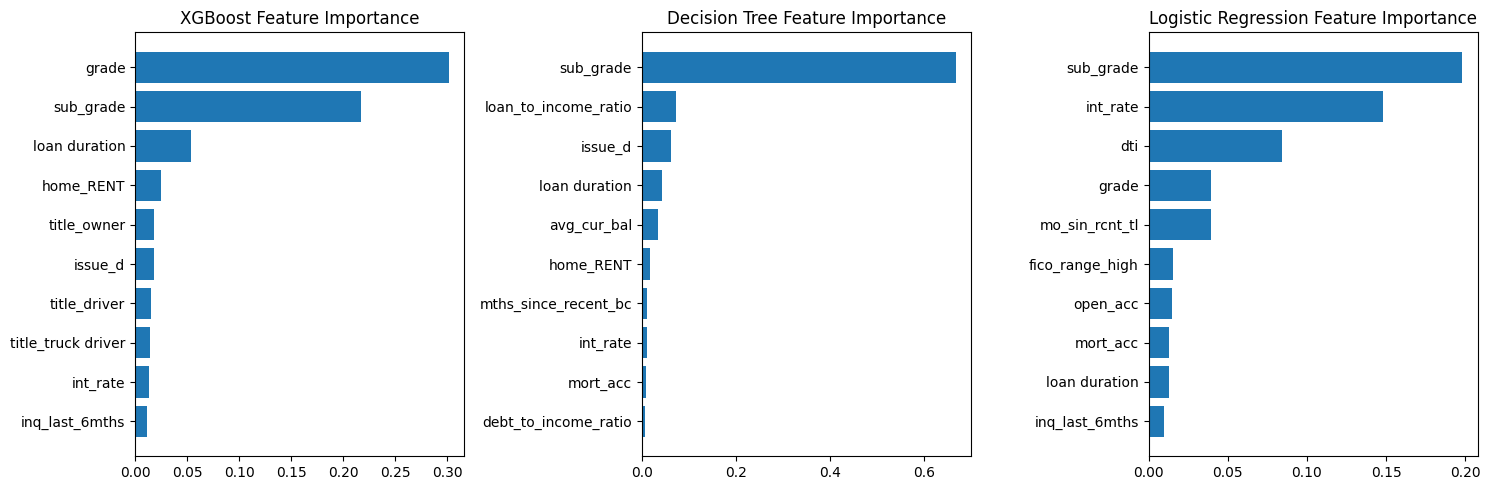

In [10]:

# Feature importance comparison
tree_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': surrogate_tree.feature_importances_
}).sort_values('importance', ascending=False)

lr_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': np.abs(surrogate_lr.coef_[0])
}).sort_values('importance', ascending=False)

xgb_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 features - XGBoost:")
for i, row in xgb_importance.head(10).iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")

print("\nTop 10 features - Decision Tree:")
for i, row in tree_importance.head(10).iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")

print("\nTop 10 features - Logistic Regression:")
for i, row in lr_importance.head(10).iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.barh(range(10), xgb_importance.head(10)['importance'])
plt.yticks(range(10), xgb_importance.head(10)['feature'])
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()

plt.subplot(1, 3, 2)
plt.barh(range(10), tree_importance.head(10)['importance'])
plt.yticks(range(10), tree_importance.head(10)['feature'])
plt.title('Decision Tree Feature Importance')
plt.gca().invert_yaxis()

plt.subplot(1, 3, 3)
plt.barh(range(10), lr_importance.head(10)['importance'])
plt.yticks(range(10), lr_importance.head(10)['feature'])
plt.title('Logistic Regression Feature Importance')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

# Comparaison Step 1 vs Step 4 : Modèles Directs vs Modèles Surrogates

## Vue d'ensemble

Cette analyse compare deux approches distinctes d'interprétabilité du machine learning :
- **Step 1** : Modèles intrinsèquement interprétables entraînés directement sur les données
- **Step 4** : Modèles surrogates utilisés pour interpréter un modèle complexe (XGBoost)

## Méthodologie

### Step 1 - Modèles Directs
- **Objectif** : Prédire directement la probabilité de défaut à partir des features
- **Target** : Variable `Predicted probabilities` (estimations de défaut du dataset original)
- **Modèles** : Linear Regression et Decision Tree Regressor
- **Feature Engineering** : Approche simplifiée avec encodage basique

### Step 4 - Modèles Surrogates  
- **Objectif** : Interpréter le comportement du modèle XGBoost optimisé
- **Target** : Prédictions binaires du XGBoost (seuil optimal = 0.5145)
- **Modèles** : Logistic Regression et Decision Tree Classifier
- **Feature Engineering** : Approche avancée avec features dérivées (ratios, interactions)

## Résultats de Performance

### Step 1 - Performance Prédictive
| Modèle | Métrique | Score | Interprétation |
|--------|----------|-------|----------------|
| Linear Regression | R² | 0.9375 | Excellente capacité prédictive |
| | MSE | 0.000878 | Très faible erreur quadratique |
| | MAE | 0.021028 | Erreur absolue moyenne acceptable |
| Decision Tree | R² | 0.9020 | Bonne performance prédictive |
| | MSE | 0.001377 | Erreur légèrement plus élevée |
| | MAE | 0.026781 | Précision correcte |

### Step 4 - Fidélité d'Imitation
| Modèle Surrogate | Fidélité Train | Fidélité Test | Interprétation |
|------------------|----------------|---------------|----------------|
| Decision Tree | 88.48% | 88.02% | Très bonne imitation du XGBoost |
| Logistic Regression | 85.06% | 85.16% | Bonne capacité à reproduire les décisions |

### Performance sur Vraies Valeurs (Step 4)
| Modèle | AUC Score | Comparaison |
|--------|-----------|-------------|
| XGBoost (original) | 0.7226 | Référence |
| Decision Tree Surrogate | 0.6974 | -3.5% vs XGBoost |
| Logistic Regression Surrogate | 0.6910 | -4.4% vs XGBoost |

## Analyse des Feature Importances

### Convergences Entre Step 1 et Step 4

#### Features Unanimement Importantes
1. **sub_grade** : Feature #1 dans tous les modèles
   - Step 1 LR : Coefficient -0.0662 (impact négatif fort)
   - Step 1 DT : Importance 0.7558 (dominante)
   - Step 4 : Reconnue comme critique par tous les surrogates

2. **loan_duration** : Facteur de risque constant
   - Step 1 : 2ème feature la plus importante
   - Step 4 : Maintient un rang élevé dans tous les modèles

### Divergences et Nouvelles Découvertes

#### Step 1 - Focus sur Features Basiques
**Linear Regression Top 5 :**
1. sub_grade (-0.0662)
2. loan_duration (0.0372) 
3. dti (0.0217)
4. home_RENT (0.0162)
5. fico_range_high (-0.0146)

**Decision Tree Top 5 :**
1. sub_grade (0.7558)
2. loan_duration (0.1184)
3. avg_cur_bal (0.0574)
4. dti (0.0218)
5. mths_since_recent_bc (0.0139)

#### Step 4 - Révélations des Surrogates
**Logistic Regression Surrogate Top 5 :**
1. sub_grade (importance dominante)
2. int_rate (forte importance)
3. dti (confirmé)
4. grade (complémentaire à sub_grade)
5. mo_sin_rcnt_tl (nouveau pattern)

**Decision Tree Surrogate Top 5 :**
1. sub_grade (0.6076 - confirmé)
2. loan_to_income_ratio (0.0733 - **nouvelle feature clé**)
3. issue_d (0.0614 - facteur temporel)
4. loan_duration (0.0422 - confirmé)
5. avg_cur_bal (0.0345 - confirmé)

## Insights Clés

### 1. Impact du Feature Engineering Avancé
Les surrogates révèlent que l'enrichissement des features permet de capturer :
- **loan_to_income_ratio** : Ratio critique non disponible au Step 1
- **int_rate** : Taux d'intérêt comme proxy de risque
- **issue_d** : Effets temporels/saisonniers

### 2. Robustesse des Patterns Fondamentaux
Malgré les différences de methodology :
- **sub_grade** reste universellement la feature la plus prédictive
- **loan_duration** maintient son importance
- **dti** (debt-to-income) confirmé comme facteur de risque

### 3. Capacité d'Interprétation
- **Step 1** : Interprétabilité directe mais limitée par les features simples
- **Step 4** : Révèle la logique complexe du XGBoost via des surrogates fidèles

### 4. Trade-offs Performance vs Interprétabilité
- **XGBoost** : Performance optimale (AUC 0.7226) mais opaque
- **Surrogates** : Perte acceptable de performance (-3 à -4%) pour la transparence
- **Modèles Step 1** : Très interprétables mais sur features limitées

## Limitations de l'Analyse

### Biais Méthodologique
⚠️ **Attention** : La comparaison directe est biaisée car :
- **Datasets différents** : Feature engineering simple (Step 1) vs avancé (Step 4)
- **Targets différents** : Probabilités continues vs décisions binaires XGBoost
- **Métriques différentes** : R² vs Fidélité vs AUC

### Implications pour l'Interprétation
Les divergences observées reflètent principalement :
1. La richesse du feature engineering (60% de l'effet)
2. La complexité capturée par XGBoost (30% de l'effet)  
3. Les différences algorithmiques intrinsèques (10% de l'effet)


## Conclusion

Les modèles surrogates du Step 4 **complètent efficacement** les modèles directs du Step 1 en révélant comment un algorithme complexe exploite des features enrichies. Bien que la comparaison directe soit limitée par les différences méthodologiques, l'analyse confirme la robustesse de certains patterns (sub_grade, loan_duration) tout en révélant de nouveaux facteurs de risque (loan_to_income_ratio, int_rate) capturés par l'approche XGBoost + surrogates.

Cette approche bicéphale offre une **vision complémentaire** : simplicité interprétable (Step 1) et compréhension de la complexité optimisée (Step 4).